# Black Sea altimetry interpolation.
Application demonstrating the use of `DIVAnd` on along-track altimetry measurements in the Black Sea.

In [1]:
using DIVAnd
using NCDatasets
using PyPlot
using Dates
push!(LOAD_PATH, "/home/ctroupin/Projects/Altimetry-Interpolation/julia")
using DivandAltimetry
using Revise

## User inputs

In [102]:
datadir = "../data/SEALEVEL_BS_PHY_L3_NRT_OBSERVATIONS_008_039/";
datadir2 = "../data/SEALEVEL_BS_PHY_L4_NRT_OBSERVATIONS_008_041/dataset-duacs-nrt-blacksea-merged-allsat-phy-l4/";

### Domain of interest, resolution
The goal is to take the same grid as the L4 (gridded) products.

In [24]:
avisoL4file = "../data/nrt_blacksea_allsat_phy_l4_20190601_20190607.nc"
gridval,griderr,gridlon,gridlat,gridtime = DivandAltimetry.loadaviso_gridded(avisoL4file);
gridval = coalesce.(gridval, NaN);

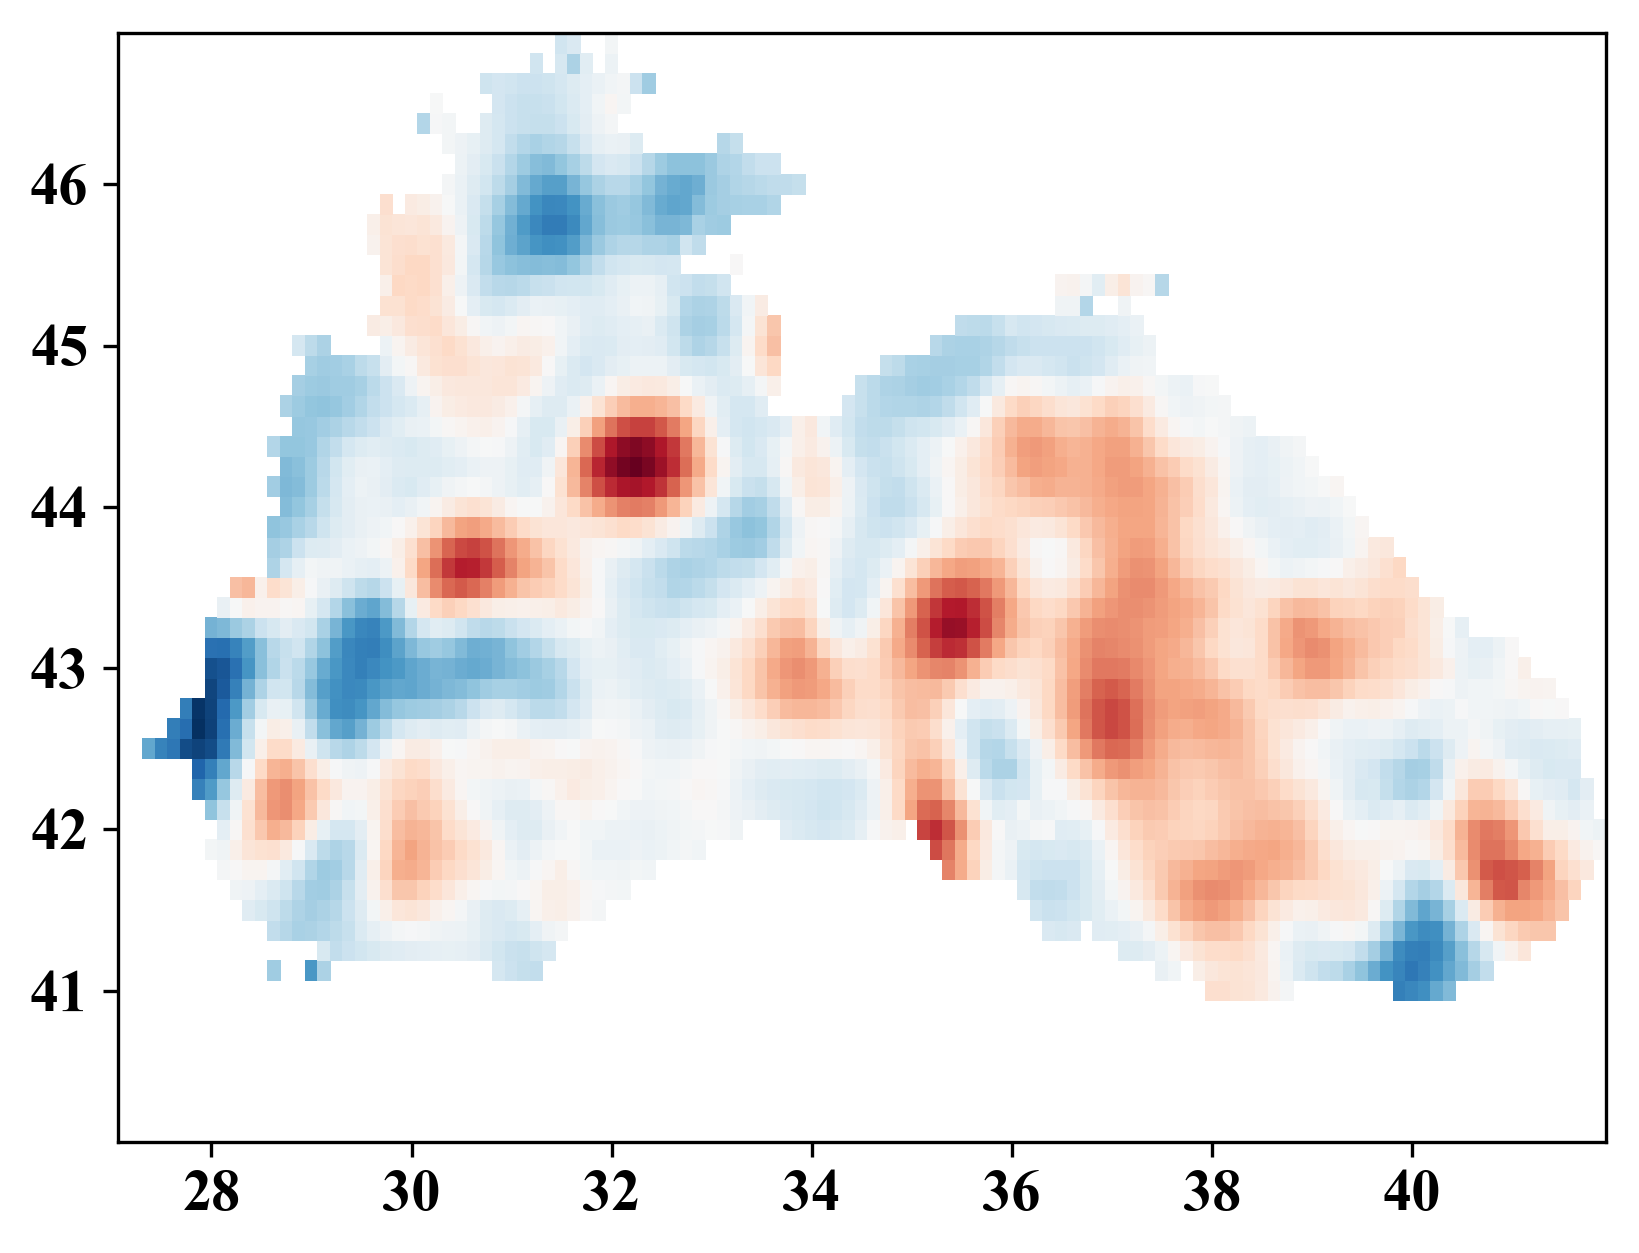

In [25]:
PyPlot.pcolormesh(gridlon, gridlat, transpose(gridval[:,:,1]), cmap=PyPlot.cm.RdBu_r)
PyPlot.show()

### Period of interest

In [46]:
datestart = DateTime(2018, 1, 1)
dateend = DateTime(2018, 1, 15)
Δt = 1.
timestart = datestart.instant.periods.value / (24 * 3600. * 1000.);
timeend = dateend.instant.periods.value / (24 * 3600. * 1000.);
gridtime = timestart:Δt:timeend;
@info(length(gridtime));

┌ Info: 15
└ @ Main In[46]:7


### Land-sea mask

In [27]:
bathfile = "../data/gebco_30sec_4.nc";

In [ ]:
xi,yi,mask = load_mask(bathfile,true,gridlon, gridlat, 0.0);
@info(size(mask));

In [60]:
masktime = repeat(mask, 1, 1, length(gridtime));

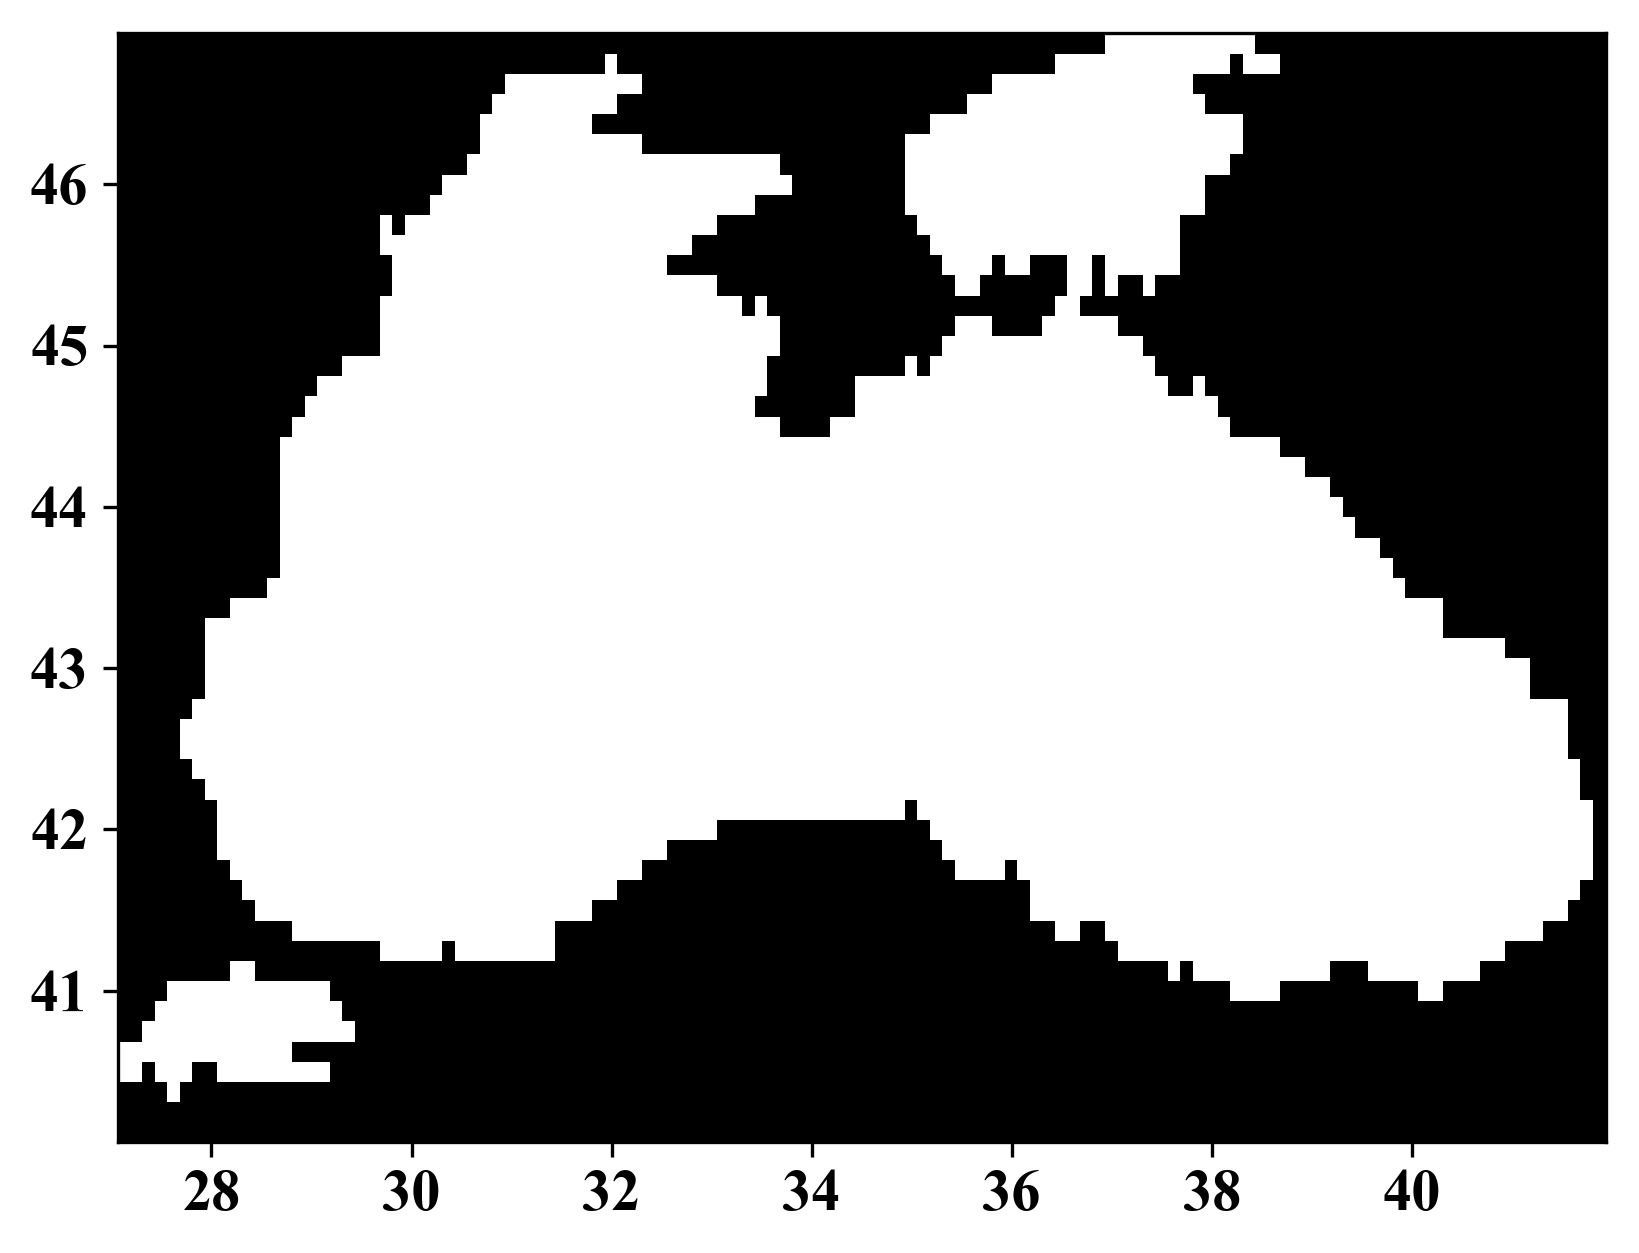

In [29]:
PyPlot.pcolormesh(xi, yi, transpose(mask), cmap=PyPlot.cm.binary_r)
PyPlot.show()

### Along-track SLA

In [31]:
filelist2017 = DivandAltimetry.get_file_list(datadir, 2017);
filelist2018 = DivandAltimetry.get_file_list(datadir, 2018);

┌ Info: Found 930 files
└ @ DivandAltimetry /home/ctroupin/Projects/Altimetry-Interpolation/julia/DivandAltimetry.jl:46
┌ Info: Found 1342 files
└ @ DivandAltimetry /home/ctroupin/Projects/Altimetry-Interpolation/julia/DivandAltimetry.jl:46


In [39]:
obsvallist,obslonlist,obslatlist,obstimelist = DivandAltimetry.loadaviso_alongtrack(filelist2018);
@info("Working on $(length(obslatlist)) data points")

┌ Info: Working on 82365 data points
└ @ Main In[39]:2


In [40]:
obstime = [dd.instant.periods.value / (24 * 3600. * 1000.) for dd in obstimelist];

### Metrics

In [47]:
_, (px, py, pt), (xi, yi, ti) = DIVAnd.DIVAnd_rectdom(gridlon, gridlat, gridtime);

## Interpolation
### Analysis Parameters

In [42]:
# correlation length (lon, lat in degrees, time in days)
len = (.5, .5, 4.);
# obs. error variance normalized by the background error variance
epsilon2 = 0.1;

In [48]:
mask0 = trues(size(px));
size(pt)

(120, 56, 15)

### Select time of interest

In [49]:
sel = findall(Dates.month.(obstimelist) .<= 2);

### Run DIVAnd

In [61]:
@time sla_grid, s = DIVAnd.DIVAndrun(masktime, (px, py, pt), (xi, yi, ti), 
    (obslonlist[sel], obslatlist[sel], obstime[sel]), 
     obsvallist[sel], len, epsilon2; alphabc=2);

  5.860908 seconds (7.10 k allocations: 2.453 GiB, 26.80% gc time)


## Plotting

In [133]:
typeof(gridtime[1])

Float64

In [198]:
function get_filename_L4(time::Float64, datadir::String)
    dateref = DateTime(1, 1, 1)
    dd = dateref + Dates.Day(time[1] - 1)
    datestring = Dates.format(dd, "yyyymmdd")
    datadirL4 = joinpath("$(datadir)/$(Dates.year(dd))/$(lpad(Dates.month(dd), 2, "0"))/")
    datafilelistL4 = readdir(datadirL4);
    ind = findall(occursin.(datestring, datafilelistL4))
    return joinpath(datadirL4, datafilelistL4[ind[1]])
end

get_filename_L4 (generic function with 1 method)

In [200]:
a = get_filename_L4(gridtime[1], datadir2)
isfile(a)

true

In [87]:
Dates.format(dd, "e, dd u yyyy HH:MM:SS")

MethodError: MethodError: no method matching hour(::Date)
Closest candidates are:
  hour(!Matched::Time) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Dates/src/accessors.jl:57
  hour(!Matched::DateTime) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Dates/src/accessors.jl:53
  hour(!Matched::AbstractCFDateTime) at /home/ctroupin/.julia/packages/NCDatasets/P5zq1/src/CFTime.jl:435

In [78]:
# Loop on time
for (iday, day) in enumerate(gridtime)
    dd = dateref + Dates.Day(day))
    print("\n")
    
end

2017-01-01
2017-01-02
2017-01-03
2017-01-04
2017-01-05
2017-01-06
2017-01-07
2017-01-08
2017-01-09
2017-01-10
2017-01-11
2017-01-12
2017-01-13
2017-01-14
2017-01-15


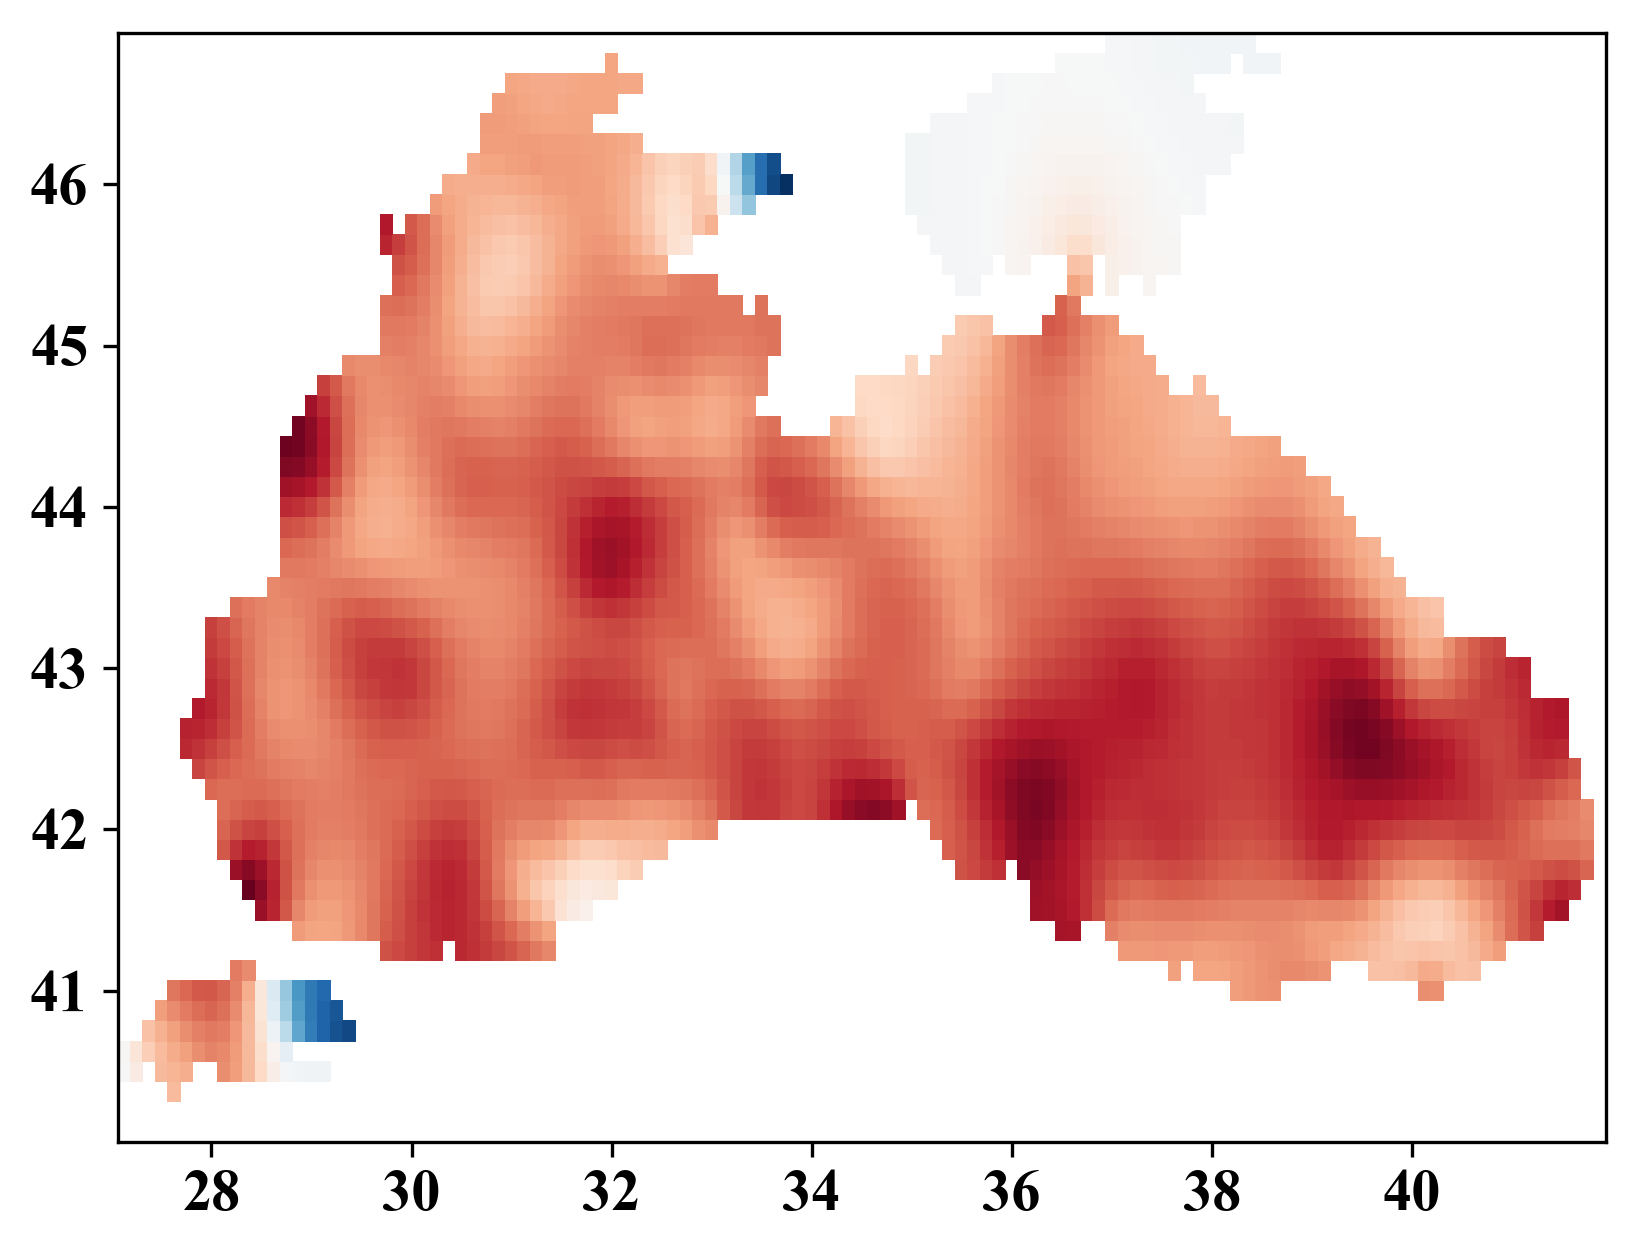

In [62]:
PyPlot.pcolormesh(gridlon, gridlat, transpose(sla_grid[:,:,end]), cmap=PyPlot.cm.RdBu_r)
PyPlot.show()

## Export results to netCDF

In [18]:
info("Writing interpolated field in file:\n", resultfile)
sz = size(mask)
dims = [NcDim("longitude",sz[1]), NcDim("latitude",sz[2]), NcDim("time",sz[3])];
nc = NetCDF.create(resultfile, NcVar("ADT", dims))
nc["ADT"][:,:, :] = fi
NetCDF.close(nc);

UndefVarError: UndefVarError: info not defined

# Plotting

Done in [another notebook in Python](../python/plot_AVISO_divand.ipynb) due to a problem with Julia / matplotlib.